In [1]:
import os
import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt
import pickle
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
nodes = pd.read_csv('../data/nodes_condesed.csv')
edges = pd.read_csv('../data/edges_condesed.csv')

# remove : character from column names to make them queryable
nodes = gt.remove_colons(nodes)
edges = gt.remove_colons(edges)

In [3]:
comps = (nodes['LABEL'] == 'Chemicals & Drugs').sum() 
diseases = (nodes['LABEL'] == 'Disorders').sum()

print('{:,} Compounds x {:,} Diseases = {:,} C-D pairs'.format(comps, diseases, comps*diseases))

98,547 Compounds x 43,228 Diseases = 4,259,989,716 C-D pairs


In [4]:
nodes.head(2)

,ID,name,LABEL
0,C0038195,State Medicine,Activities & Behaviors
1,C0233512,Normal behavior,Activities & Behaviors


In [5]:
edges.head(2)

,START_ID,END_ID,TYPE,pmids
0,C1273870,C0282623,ADMINISTERED_TO_ABatAB,1
1,C0441648,C0221192,ADMINISTERED_TO_ABatCI,2


In [6]:
counts = edges["TYPE"].value_counts()
counts

ASSOCIATED_WITH_CDawCD         1415748
LOCATION_OF_AloCD              1048781
INTERACTS_WITH_CDiwG            732705
ASSOCIATED_WITH_DOawDO          712286
TREATS_CDtDO                    634946
AFFECTS_DOafLB                  627265
ASSOCIATED_WITH_CDawDO          613957
LOCATION_OF_AloG                566189
LOCATION_OF_AloDO               563006
PRODUCES_LBpdCD                 525948
STIMULATES_CDst>CD              512811
TREATS_PRtDO                    446603
INHIBITS_CDinCD                 439092
AUGMENTS_CDagDO                 414322
STIMULATES_CDstG                386302
AFFECTS_CDafPS                  367386
AFFECTS_CDafA                   336482
ASSOCIATED_WITH_GawDO           327017
AUGMENTS_DOag>DO                303738
USES_PRuCD                      293601
LOCATION_OF_AloA                274594
PART_OF_GpoLB                   273154
AFFECTS_GafPS                   262443
INTERACTS_WITH_GiwG             248477
INHIBITS_CDinG                  242474
ISA_CDi>CD               

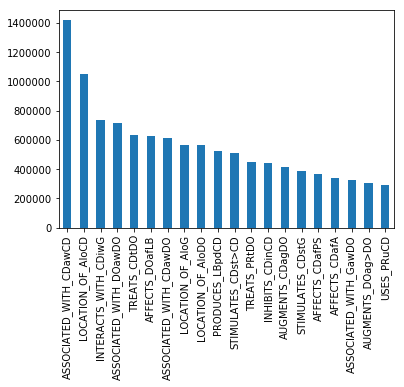

In [7]:
counts[:20].plot(kind='bar');

# Filter out the lower count edge types

In [8]:
'{:,}'.format(edges.shape[0])

'17,730,091'

In [9]:
cutoff = .001

print("Number of edge types with this cutoff: {}".format((counts > cutoff*len(edges)).sum()))
print("Number of edges that remain with this cutoff: {:,}".format(counts[counts > cutoff*len(edges)].sum()))

Number of edge types with this cutoff: 75
Number of edges that remain with this cutoff: 16,693,497


In [10]:
ok_edges = list(counts[counts > cutoff*len(edges)].index)

In [11]:
result = edges.query('TYPE in @ok_edges')

In [12]:
'{:,}'.format(result.shape[0])

'16,693,497'

# Some quick validation that all ids are the same between nodes and edges

In [13]:
edge_ids = set(result['START_ID'].unique()).union(set(result['END_ID'].unique()))

In [14]:
node_ids = set(nodes['ID'].unique())

In [15]:
not_in_edges = node_ids - edge_ids

In [16]:
not_in_edges = list(not_in_edges)

In [17]:
idx = nodes.query('ID in @not_in_edges').index
nodes.loc[idx]

,ID,name,LABEL
0,C0038195,State Medicine,Activities & Behaviors
1,C0233512,Normal behavior,Activities & Behaviors
2,C0680431,Apartheid,Activities & Behaviors
3,C0037400,Social Change,Activities & Behaviors
4,C0078912,Aikido,Activities & Behaviors
5,C0680718,arraignment,Activities & Behaviors
6,C0282352,National Security,Activities & Behaviors
7,C0024818,Marital Relationship,Activities & Behaviors
11,C0871808,Management Methods,Activities & Behaviors
12,C1521911,NCI Unconventional Innovations Program,Activities & Behaviors


In [18]:
nodes = nodes.drop(idx)

In [19]:
len(nodes)

258184

In [20]:
# Sort values before writing to disk
result = result.sort_values('TYPE')
nodes = nodes.sort_values('LABEL')

# Add in colons required by neo4j
nodes = gt.add_colons(nodes)
result = gt.add_colons(result)

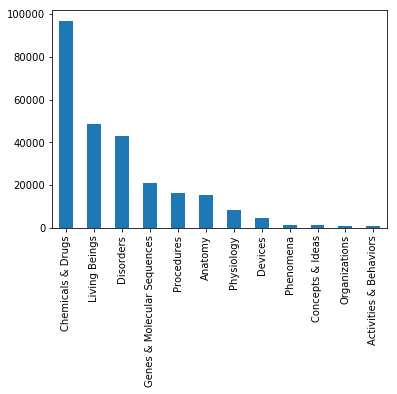

In [21]:
nodes[':LABEL'].value_counts().plot(kind='bar');

# Do some EDA

In [22]:
combo = gt.combine_nodes_and_edges(nodes, result)
combo = gt.remove_colons(combo)

In [23]:
combo.head(2)

,START_ID,END_ID,TYPE,pmids,start_name,end_name,start_label,end_label
1906,C0017932,C0030705,ADMINISTERED_TO_CDatLB,1,Glycogen (Starch) Synthase,Patients,Chemicals & Drugs,Living Beings
65676,C0057609,C0034693,ADMINISTERED_TO_CDatLB,1,dexoxadrol,Rattus norvegicus,Chemicals & Drugs,Living Beings


In [24]:
max_edge = combo["pmids"].max()
combo.query('pmids == @max_edge')

,START_ID,END_ID,TYPE,pmids,start_name,end_name,start_label,end_label
16941069,C0087111,C0030705,TREATS_PRtLB,136117,Therapeutic procedure,Patients,Procedures,Living Beings


In [25]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = combo.query('pmids > @i')['TYPE'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot

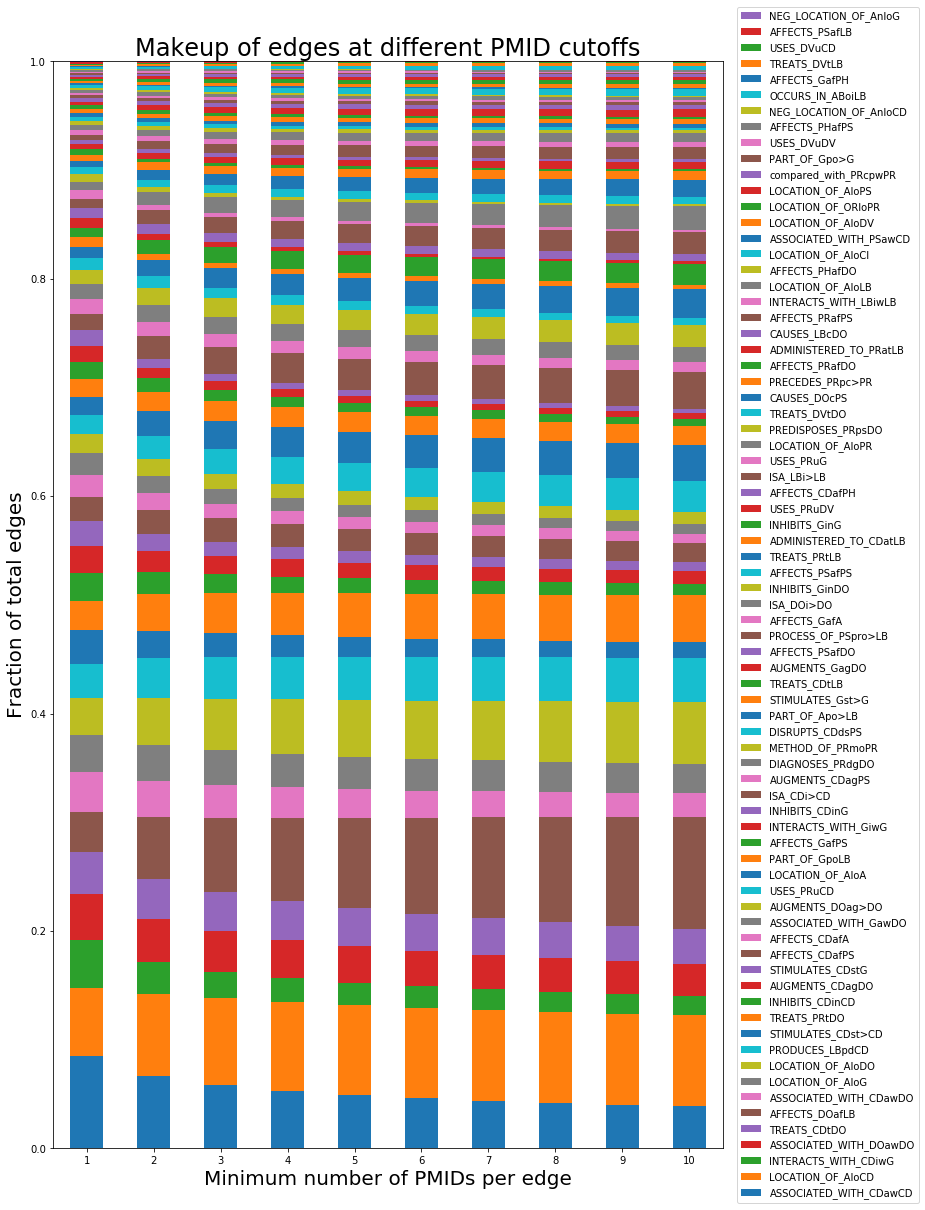

In [26]:
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

In [27]:
combo.sort_values('pmids', ascending=False)[['pmids', 'start_name', 'TYPE', 'end_name']].iloc[:60]

,pmids,start_name,TYPE,end_name
16941069,136117,Therapeutic procedure,TREATS_PRtLB,Patients
1303775,92769,Disease,AFFECTS_DOafLB,Patients
17011498,89997,Operative Surgical Procedures,TREATS_PRtLB,Patients
1303773,62216,Symptoms,AFFECTS_DOafLB,Patients
1303772,57232,Malignant Neoplasms,AFFECTS_DOafLB,Patients
1303771,52424,Diabetic,AFFECTS_DOafLB,Patients
1303769,50383,Complication,AFFECTS_DOafLB,Patients
13186126,45915,Liver,PART_OF_Apo>LB,Rattus norvegicus
13186140,45542,Brain,PART_OF_Apo>LB,Rattus norvegicus
1303766,45428,Neoplasm,AFFECTS_DOafLB,Patients


In [28]:
combo.query('START_ID == END_ID')['TYPE'].value_counts()

INTERACTS_WITH_GiwG      3557
STIMULATES_Gst>G         2729
INHIBITS_GinG            2174
compared_with_PRcpwPR    1774
PART_OF_Gpo>G             939
Name: TYPE, dtype: int64

There are some instances of self-referrential edges.  These should be removed as they are not vaild in DWPC feature extraction.

In [29]:
result = gt.remove_colons(result)
idx = result.query('START_ID == END_ID').index
result = result.drop(idx)

In [30]:
node_degrees = pd.concat([combo['start_name'], combo['end_name']]).value_counts()

In [31]:
node_degrees[:60]

Patients                         98820
Disease                          68988
Therapeutic procedure            66369
Cells                            64386
Proteins                         51775
Pharmaceutical Preparations      50470
Rattus norvegicus                49111
Mus                              43511
Human                            42948
Child                            40553
Neoplasm                         39410
Genes                            39045
Woman                            34747
Malignant Neoplasms              34597
Growth                           34210
Body tissue                      32078
DNA                              30594
Individual                       30461
Antibodies                       30201
Brain                            29076
Operative Surgical Procedures    28514
Adult                            27427
Liver                            27413
Enzymes                          27071
Symptoms                         26930
Syndrome                 

In [32]:
#These are from the 100 most common nodes, removing things that are too general to be usefl

too_general = ['Patients', 'Cells', 'Disease', 'Therapeutic procedure', 'Proteins', 'Pharmaceutical Preparations',
 'Mus', 'Human', 'Child', 'Genes', 'Woman', 'Body tissue', 'Malignant Neoplasms', 'Growth', 'Individual', 'Antibodies',
 'Operative Surgical Procedures', 'Adult', 'Enzymes', 'Symptoms', 'Syndrome', 'Animals', 'Cell Line', 'Injury', 'Complication',
 'House mice', 'Functional disorder', 'Infant', 'Family', 'Persons', 'Male population group', 'Monoclonal Antibodies',
 'Toxic effect', 'Infection', 'DNA Sequence', 'Control Groups', 'Injection procedure', 'Ions', 'Transcription, Genetic',
 'Organ', 'TRANSCRIPTION FACTOR', 'cohort']

In [33]:
idx = nodes.query('name in @too_general').index
nodes = nodes.drop(idx).reset_index(drop=True)

In [34]:
node_ids = nodes[':ID'].unique()

In [35]:
result = result.query('START_ID in @node_ids and END_ID in @node_ids')

In [36]:
'{:,} Edges remain'.format(len(result))

'15,379,509 Edges remain'

In [37]:
result = gt.add_colons(result)

result.to_csv('../data/edges_condensed_filtered_001.csv', index=False)
nodes.to_csv('../data/nodes_condensed_filtered_001.csv', index=False)

In [42]:
gt.remove_colons(nodes).query('LABEL == "Phenomena"')

,ID,name,LABEL
232366,C0853719,Cerebrospinal fluid culture positive,Phenomena
232367,C0427593,Factor VII level,Phenomena
232368,C0947211,VISUAL SENSORY,Phenomena
232369,C0580948,Carboxyhemoglobin level,Phenomena
232370,C0563034,Aquatic environment,Phenomena
232371,C0337000,Cyclone,Phenomena
232372,C1328815,nitration,Phenomena
232373,C0427535,Giant granulation,Phenomena
232374,C1261228,Plasma hemoglobin level observed,Phenomena
232375,C0855854,Allergen NOS skin test positive,Phenomena


In [45]:
result.drop_duplicates(subset=[':TYPE'])

,:START_ID,:END_ID,:TYPE,pmids
65676,C0057609,C0034693,ADMINISTERED_TO_CDatLB,1
147660,C0040808,C0324180,ADMINISTERED_TO_PRatLB,1
395973,C0029904,C1514733,AFFECTS_CDafA,1
586145,C0005198,C0032931,AFFECTS_CDafPH,1
858190,C0225326,C0871470,AFFECTS_CDafPS,1
1412069,C0275699,C0014834,AFFECTS_DOafLB,1
1712563,C1335244,C0023884,AFFECTS_GafA,1
1775443,C1414103,C0678590,AFFECTS_GafPH,1
1958103,C1420679,C0002345,AFFECTS_GafPS,1
2078612,C0034538,C0020517,AFFECTS_PHafDO,14


In [46]:
combo.query('TYPE == "AFFECTS_CDafPS"')

,START_ID,END_ID,TYPE,pmids,start_name,end_name,start_label,end_label
858190,C0225326,C0871470,AFFECTS_CDafPS,1,Fiber,Systolic Pressure,Chemicals & Drugs,Physiology
858193,C0002257,C0597304,AFFECTS_CDafPS,1,alpha-Crystallins,Proteolysis,Chemicals & Drugs,Physiology
858192,C0877970,C0042401,AFFECTS_CDafPS,1,Rocornal,Vasodilation,Chemicals & Drugs,Physiology
858194,C0908595,C0080310,AFFECTS_CDafPS,1,SM 20550,"Ventricular Function, Left",Chemicals & Drugs,Physiology
858189,C0075689,C0086934,AFFECTS_CDafPS,1,Synaptosomal-Associated Protein 25,"RNA, Messenger, Splicing",Chemicals & Drugs,Physiology
858191,C0079249,C1446949,AFFECTS_CDafPS,1,"DNA, Antisense",Preimplantation Embryo Development,Chemicals & Drugs,Physiology
858188,C0021212,C0036658,AFFECTS_CDafPS,1,Indicators,Esthesia,Chemicals & Drugs,Physiology
858181,C0299636,C0596620,AFFECTS_CDafPS,1,somatostatin receptor 5,glucose metabolism,Chemicals & Drugs,Physiology
858186,C1505817,C0302600,AFFECTS_CDafPS,1,"HPSE protein, human",Angiogenesis,Chemicals & Drugs,Physiology
858185,C0123538,C1519618,AFFECTS_CDafPS,1,Heterogeneous-Nuclear Ribonucleoproteins,Translational Regulation,Chemicals & Drugs,Physiology
